<a href="https://colab.research.google.com/github/Ali-Khatib/Financial-Fraud-Detection-Using-Deep-Learning-and-Hybrid-Autoencoder-MLP/blob/main/Fraud_Detection_Using_DL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Config

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

import kagglehub


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import (
    confusion_matrix, classification_report,
    auc,
)

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers


warnings.filterwarnings('ignore')
print("All Imports are ready :D")

All Imports are ready :D


# Data Exploration

In [ ]:
path = kagglehub.dataset_download("amanalisiddiqui/fraud-detection-dataset")

csv_file = os.path.join(path, "AIML Dataset.csv")
df = pd.read_csv(csv_file)

df.head()


100%|██████████| 178M/178M [00:00<00:00, 236MB/s]

Extracting files...


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df["isFraud"].value_counts()

,count
isFraud,
0,6354407
1,8213


In [ ]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


Text(0.5, 1.0, 'Class Distribution (Normal vs Fraud)')

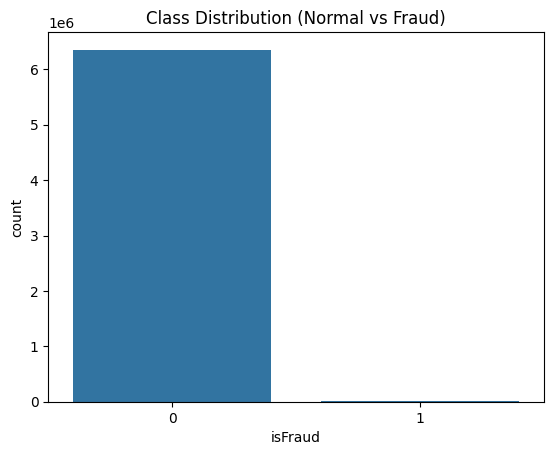

In [ ]:
sns.countplot(x=df['isFraud'])
plt.title("Class Distribution (Normal vs Fraud)")

Text(0.5, 1.0, 'Transaction Amount Distribution (Normal vs Fraud)')

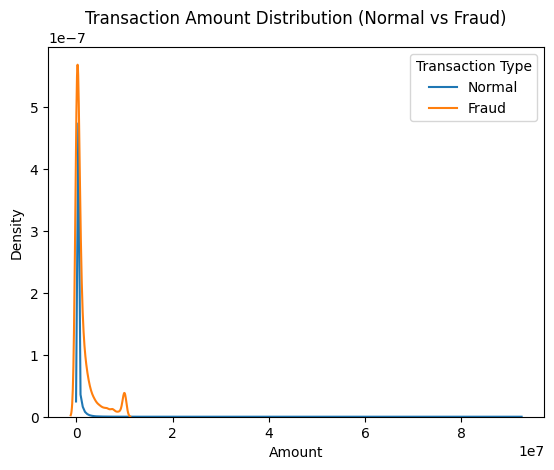

In [ ]:
sns.kdeplot(df[df.isFraud==0]['amount'], label='Normal')
sns.kdeplot(df[df.isFraud==1]['amount'], label='Fraud')

plt.legend(title="Transaction Type")
plt.xlabel("Amount")
plt.ylabel("Density")
plt.title("Transaction Amount Distribution (Normal vs Fraud)")


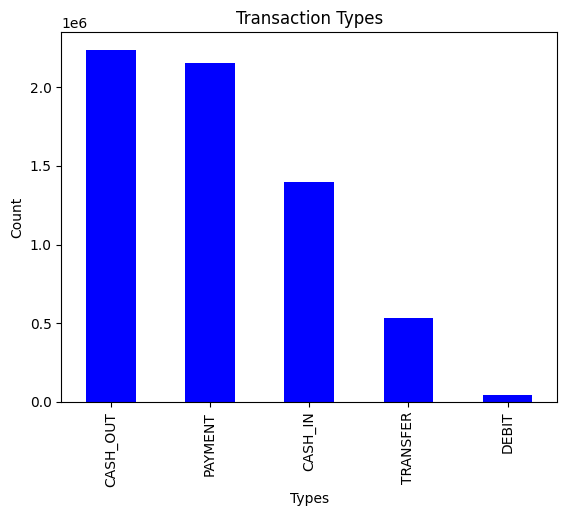

In [ ]:
 df["type"].value_counts().plot(kind="bar", color="blue", title="Transaction Types")
plt.xlabel("Types")
plt.ylabel("Count")
plt.show()

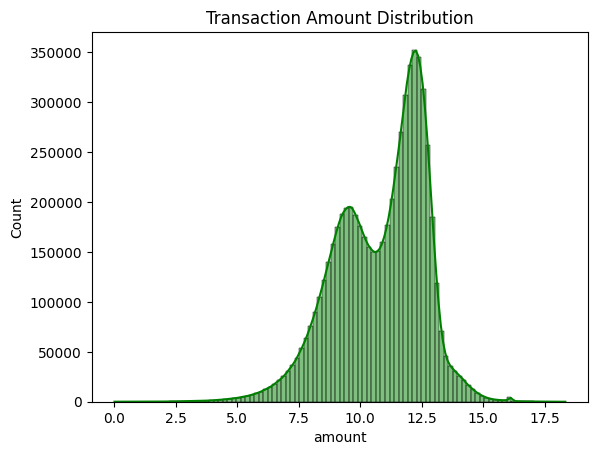

In [ ]:
sns.histplot(np.log1p(df["amount"]), bins=100, kde=True, color='green')
plt.title("Transaction Amount Distribution")
plt.show()

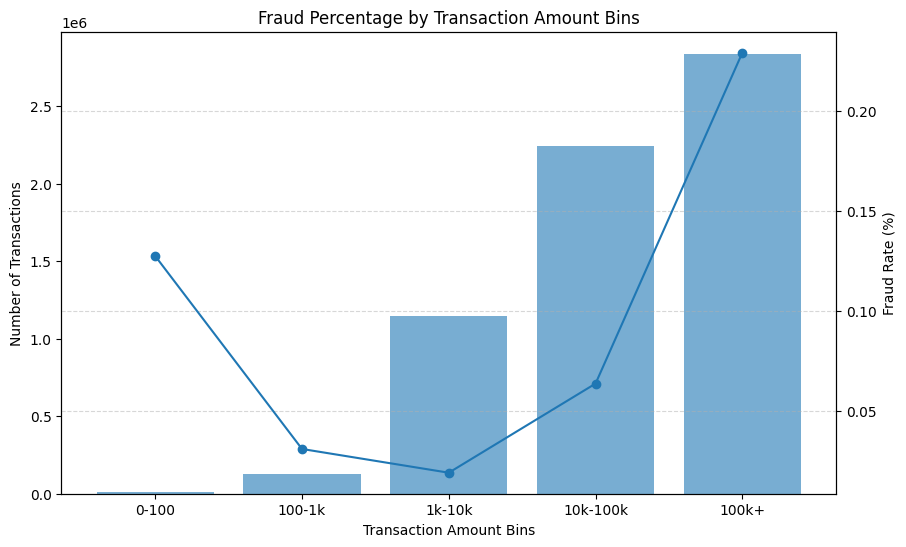

In [ ]:
bins = [0, 100, 1000, 10000, 100000, df['amount'].max()]
labels = ["0-100", "100-1k", "1k-10k", "10k-100k", "100k+"]

df['amount_bin'] = pd.cut(df['amount'], bins=bins, labels=labels, include_lowest=True)


bin_counts = df['amount_bin'].value_counts().sort_index()
bin_fraud_rate = df.groupby('amount_bin')['isFraud'].mean().sort_index() * 100


fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(labels, bin_counts, alpha=0.6)
ax1.set_xlabel("Transaction Amount Bins")
ax1.set_ylabel("Number of Transactions")

ax2 = ax1.twinx()
ax2.plot(labels, bin_fraud_rate, marker='o')
ax2.set_ylabel("Fraud Rate (%)")

plt.title("Fraud Percentage by Transaction Amount Bins")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

**Explanation:**
- Fraudsters target the highest-value transactions:

Fraud attempts concentrate on large amounts where the reward is greatest.

- Mid-range transactions are mostly legitimate:

These likely represent routine business operations, with minimal fraudulent activity.

- Small-value transactions show little fraud:

Low amounts are not worth the effort for fraudsters.

# Feature Engineering


In [ ]:
df['orig_balance_change'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_change'] = df['newbalanceDest'] - df['oldbalanceDest']
df['amount_ratio_orig'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['amount_ratio_dest'] = df['amount'] / (df['oldbalanceDest'] + 1)


df.dtypes

,0
step,int64
type,object
amount,float64
nameOrig,object
oldbalanceOrg,float64
newbalanceOrig,float64
nameDest,object
oldbalanceDest,float64
newbalanceDest,float64
isFraud,int64


# Encoding Categorical Variables


In [ ]:
ohe = OneHotEncoder(sparse_output=False,drop='first')
type_encoded = ohe.fit_transform(df[['type']])
type_df = pd.DataFrame(type_encoded, columns=ohe.get_feature_names_out(['type']))
df = pd.concat([df.drop('type', axis=1), type_df], axis=1)

print("done , do not run again !!!")

done , do not run again !!!


# Train - Test sets creation

In [ ]:
feature_cols = [
    'step','amount','oldbalanceOrg','newbalanceOrig',
    'oldbalanceDest','newbalanceDest',
    'orig_balance_change','dest_balance_change',
    'amount_ratio_orig','amount_ratio_dest',
    'type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER'
]

X = df[feature_cols]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)




numeric_features = [
    'step','amount','oldbalanceOrg','newbalanceOrig',
    'oldbalanceDest','newbalanceDest',
    'orig_balance_change','dest_balance_change',
    'amount_ratio_orig','amount_ratio_dest'
]

scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print(f"Train Size: {len(X_train)}")
print(f"Test Size: {len(X_test)}")


Train Size: 4453834
Test Size: 1908786


# DNN/MLP Deep Neural Network Model

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
from sklearn.metrics import classification_report


input_dim = X_train.shape[1]

dnn = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),

    layers.Dense(1, activation='sigmoid')
])

dnn.compile(
    optimizer=optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['AUC']
)

dnn.summary()


batch_size = 256

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = (
    train_ds
    .shuffle(10000)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


class_weights = {0: 3, 1: 1}

es = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


history = dnn.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[es],
    verbose=2
)


y_probs = dnn.predict(test_ds).ravel()
threshold = 0.5
y_pred = (y_probs >= threshold).astype(int)



print("Classification Report:\n", classification_report(y_test, y_pred))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,057 (176.00 KB)

 Trainable params: 45,057 (176.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
17398/17398 - 52s - 3ms/step - AUC: 0.8928 - loss: 0.0087 - val_AUC: 0.8753 - val_loss: 0.0043
Epoch 2/20
17398/17398 - 44s - 3ms/step - AUC: 0.9054 - loss: 0.0044 - val_AUC: 0.8887 - val_loss: 0.0040
Epoch 3/20
17398/17398 - 43s - 2ms/step - AUC: 0.9126 - loss: 0.0042 - val_AUC: 0.8839 - val_loss: 0.0038
Epoch 4/20
17398/17398 - 44s - 3ms/step - AUC: 0.9141 - loss: 0.0041 - val_AUC: 0.8840 - val_loss: 0.0038
Epoch 5/20
17398/17398 - 43s - 2ms/step - AUC: 0.9177 - loss: 0.0040 - val_AUC: 0.8836 - val_loss: 0.0037
Epoch 6/20
17398/17398 - 43s - 2ms/step - AUC: 0.9203 - loss: 0.0040 - val_AUC: 0.8989 - val_loss: 0.0035
Epoch 7/20
17398/17398 - 43s - 2ms/step - AUC: 0.9222 - loss: 0.0039 - val_AUC: 0.8747 - val_loss: 0.0039
Epoch 8/20
17398/17398 - 43s - 2ms/step - AUC: 0.9272 - loss: 0.0038 - val_AUC: 0.8897 - val_loss: 0.0036
Epoch 9/20
17398/17398 - 43s - 2ms/step - AUC: 0.9267 - loss: 0.0037 - val_AUC: 0.8917 - val_loss: 0.0036
Epoch 10/20
17398/17398 - 43s - 2ms/step - AUC

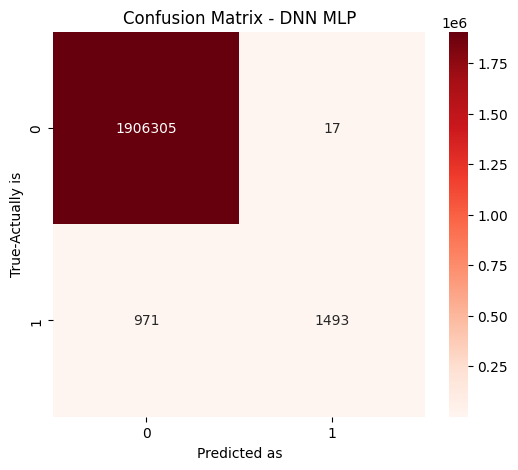

In [ ]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix - DNN MLP")
plt.xlabel("Predicted as")
plt.ylabel("True-Actually is")
plt.show()

# Hybrid AutoEncoder and MLP Model

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

X_train_nonfraud = X_train[y_train == 0].copy()  # only normal transactions
input_dim = X_train.shape[1]
latent_dim = 32  # compressed representation size

def build_autoencoder(input_dim, latent_dim):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inp)
    latent = layers.Dense(latent_dim, activation='relu', name='latent')(x)
    out = layers.Dense(input_dim, activation='linear')(latent)
    ae = models.Model(inputs=inp, outputs=out)
    encoder = models.Model(inputs=inp, outputs=latent)
    ae.compile(optimizer=optimizers.Adam(0.001), loss='mse')
    return ae, encoder

ae, encoder = build_autoencoder(input_dim, latent_dim)
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ae.fit(X_train_nonfraud, X_train_nonfraud, epochs=20, batch_size=256, validation_split=0.1, callbacks=[es], verbose=2)

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)

Epoch 1/20
15638/15638 - 31s - 2ms/step - loss: 0.0054 - val_loss: 1.6496e-04
Epoch 2/20
15638/15638 - 27s - 2ms/step - loss: 7.3295e-04 - val_loss: 5.6483e-04
Epoch 3/20
15638/15638 - 27s - 2ms/step - loss: 6.0935e-04 - val_loss: 5.8254e-05
Epoch 4/20
15638/15638 - 28s - 2ms/step - loss: 5.3638e-04 - val_loss: 1.1441e-04
Epoch 5/20
15638/15638 - 28s - 2ms/step - loss: 4.9747e-04 - val_loss: 6.2259e-05
Epoch 6/20
15638/15638 - 27s - 2ms/step - loss: 3.6266e-04 - val_loss: 1.2148e-04
Epoch 7/20
15638/15638 - 27s - 2ms/step - loss: 3.5324e-04 - val_loss: 3.1422e-05
Epoch 8/20
15638/15638 - 27s - 2ms/step - loss: 4.3493e-04 - val_loss: 5.2555e-05
Epoch 9/20
15638/15638 - 27s - 2ms/step - loss: 3.1995e-04 - val_loss: 1.3114e-05
Epoch 10/20
15638/15638 - 28s - 2ms/step - loss: 3.3416e-04 - val_loss: 5.2647e-05
Epoch 11/20
15638/15638 - 27s - 2ms/step - loss: 2.3115e-04 - val_loss: 3.2235e-05
Epoch 12/20
15638/15638 - 27s - 2ms/step - loss: 2.1835e-04 - val_loss: 1.6961e-04
Epoch 13/20
15638

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

print("Mixed precision enabled:", mixed_precision.global_policy())


batch_size = 256

train_reconstructed = ae.predict(X_train, batch_size=batch_size)
test_reconstructed  = ae.predict(X_test,  batch_size=batch_size)

train_error_recon = np.mean((X_train - train_reconstructed)**2, axis=1)
test_error_recon  = np.mean((X_test  - test_reconstructed)**2, axis=1)

# Hybrid Features
X_train_hybrid = np.column_stack([X_train, X_train_latent, train_error_recon])
X_test_hybrid  = np.column_stack([X_test,  X_test_latent,  test_error_recon])

print("Hybrid Train Shape:", X_train_hybrid.shape)
print("Hybrid Test Shape:",  X_test_hybrid.shape)


batch_size = 256

train_ds = tf.data.Dataset.from_tensor_slices((X_train_hybrid, y_train))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_hybrid, y_test))

train_ds = (train_ds
            .shuffle(10000)
            .batch(batch_size)
            .cache()
            .prefetch(tf.data.AUTOTUNE))

test_ds = (test_ds
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))


clf_input_dim = X_train_hybrid.shape[1]

clf = models.Sequential([
    layers.Input(shape=(clf_input_dim,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),

    layers.Dense(1, activation='sigmoid', dtype='float32')
])

clf.compile(
    optimizer=optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['AUC']
)

clf.summary()

Mixed precision enabled: <DTypePolicy "mixed_float16">
17398/17398 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
7457/7457 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Hybrid Train Shape: (4453834, 47)
Hybrid Test Shape: (1908786, 47)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,505 (209.00 KB)

 Trainable params: 53,505 (209.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es_clf = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
clf.fit(
    X_train_hybrid,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    callbacks=[es_clf]
)

Epoch 1/20
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - AUC: 0.9035 - loss: 0.0140 - val_AUC: 0.9525 - val_loss: 0.0043
Epoch 2/20
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - AUC: 0.9353 - loss: 0.0043 - val_AUC: 0.9058 - val_loss: 0.0041
Epoch 3/20
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - AUC: 0.9395 - loss: 0.0039 - val_AUC: 0.9404 - val_loss: 0.0036
Epoch 4/20
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - AUC: 0.9383 - loss: 0.0038 - val_AUC: 0.9399 - val_loss: 0.0036
Epoch 5/20
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - AUC: 0.9368 - loss: 0.0038 - val_AUC: 0.9360 - val_loss: 0.0036
Epoch 6/20
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - AUC: 0.9392 - loss: 0.0038 - val_AUC: 0.9426 - val_loss: 0.0035
Epoch 7/20
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - AUC: 0.9399 - loss: 0.0037 - val_AUC: 0.9232 - val_loss: 0.0036
Epoch 8/20
27837/27837 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - AUC: 0.9411 - loss: 0.0038 - val_AUC: 0.9385 - val_loss: 0.0033
Epoch 9/20
27837

59650/59650 ━━━━━━━━━━━━━━━━━━━━ 65s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.99      0.59      0.73      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.79      0.87   1908786
weighted avg       1.00      1.00      1.00   1908786



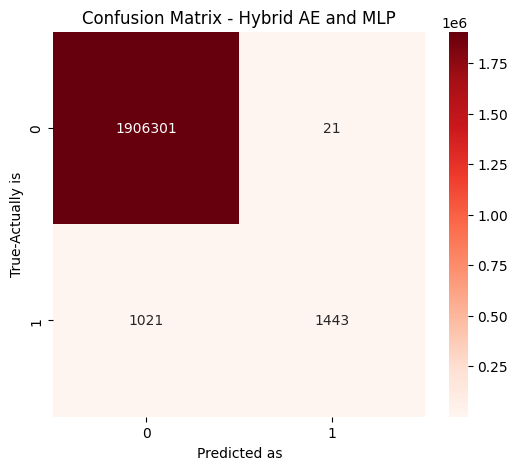

In [ ]:
y_probs = clf.predict(X_test_hybrid).ravel()
threshold = 0.5
y_test_pred = (y_probs >= threshold).astype(int)
print(classification_report(y_test, y_test_pred))


cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix - Hybrid AE and MLP")
plt.xlabel("Predicted as")
plt.ylabel("True-Actually is")
plt.show()